C:\Users\Almazt\AppData\Local\Temp\ipykernel_11392\3282553381.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_handsets = pd.read_sql_query(query_handsets, connection)


  Manufacturer                   HandsetType  usage_count
0       Huawei              Huawei B528S-23A        19752
1        Apple       Apple iPhone 6S (A1688)         9419
2        Apple        Apple iPhone 6 (A1586)         9023
3    undefined                     undefined         8987
4        Apple        Apple iPhone 7 (A1778)         6326
5        Apple       Apple iPhone Se (A1723)         5187
6        Apple        Apple iPhone 8 (A1905)         4993
7        Apple       Apple iPhone Xr (A2105)         4568
8      Samsung  Samsung Galaxy S8 (Sm-G950F)         4520
9        Apple        Apple iPhone X (A1901)         3813


C:\Users\Almazt\AppData\Local\Temp\ipykernel_11392\3282553381.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='HandsetType', y='usage_count', data=df_handsets, palette='viridis')


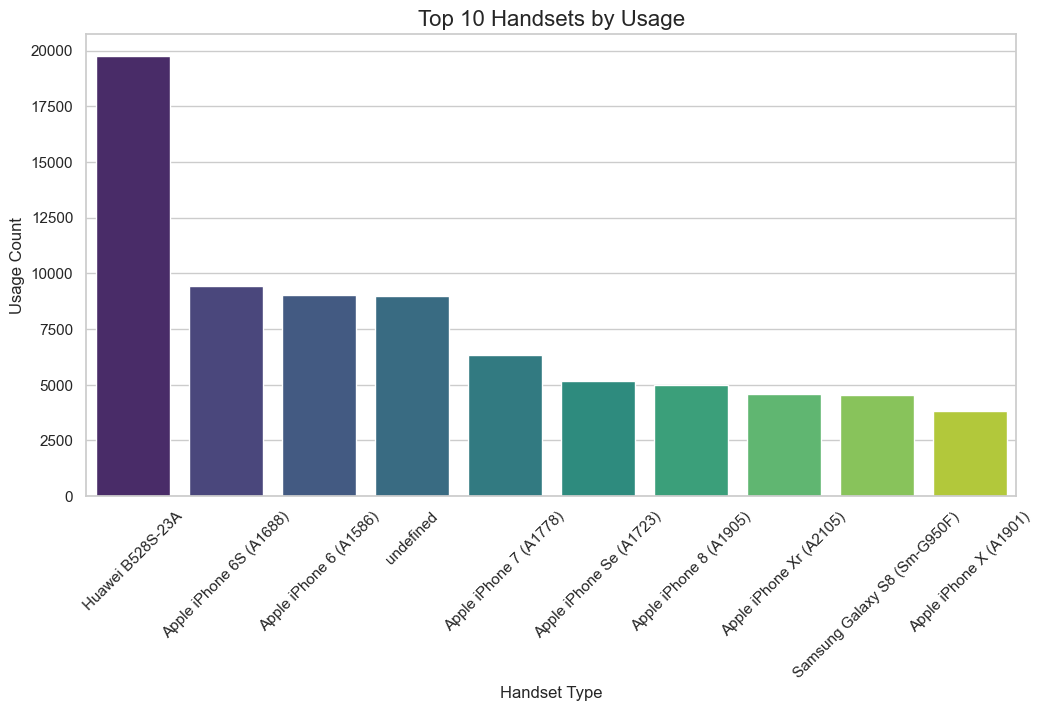

C:\Users\Almazt\AppData\Local\Temp\ipykernel_11392\3282553381.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_metrics = pd.read_sql_query(query_metrics, connection)


=== Aggregate Metrics ===
Total Sessions: 74,364,695,455,661.0
Average Session Duration: 104609105.55
Total Download: 68,196,514,511,845.0 MB
Total Upload: 6,168,180,943,816.0 MB


C:\Users\Almazt\AppData\Local\Temp\ipykernel_11392\3282553381.py:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_durations = pd.read_sql_query(query_durations, connection)
C:\Users\Almazt\AppData\Local\Temp\ipykernel_11392\3282553381.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=decile_counts.index, y=decile_counts.values, palette="coolwarm")


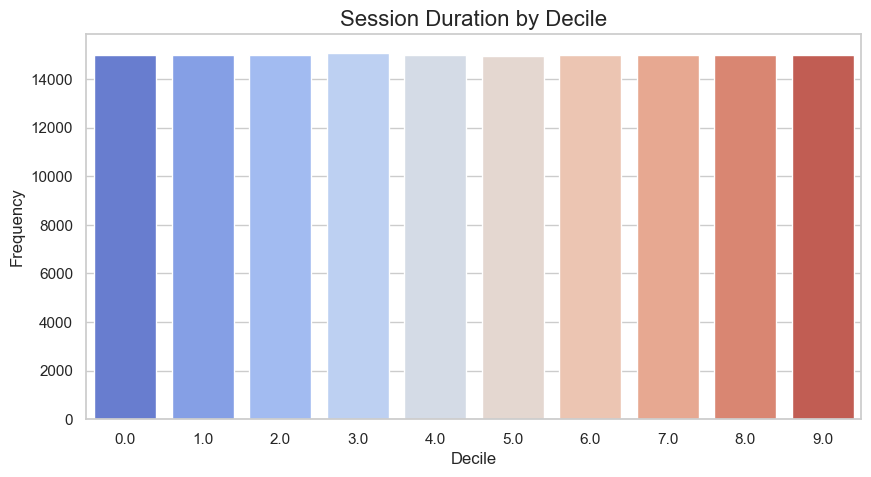

Report saved as 'report.md'. View it for insights and graphs.


In [1]:
# Import Libraries
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection
# Connect to psycopg2 database (or create it if it doesn't exist)
from sqlalchemy import create_engine

connection = psycopg2.connect("dbname=Teleco user=postgres password=Leul@123")

# Create a cursor object to interact with the database
cursor = connection.cursor()

# Set plot style
sns.set(style="whitegrid")

# Step 1: Retrieve and Document Top Handsets and Manufacturers
query_handsets = """
SELECT "Manufacturer", "HandsetType", COUNT(*) AS usage_count
FROM xdr_data
GROUP BY "Manufacturer", "HandsetType"
ORDER BY usage_count DESC
LIMIT 10;
"""
df_handsets = pd.read_sql_query(query_handsets, connection)
print(df_handsets)

# Generate Bar Plot for Top Handsets
plt.figure(figsize=(12, 6))
sns.barplot(x='HandsetType', y='usage_count', data=df_handsets, palette='viridis')
plt.title("Top 10 Handsets by Usage", fontsize=16)
plt.xlabel("Handset Type", fontsize=12)
plt.ylabel("Usage Count", fontsize=12)
plt.xticks(rotation=45)
plt.savefig("top_handsets.png")  # Save the figure
plt.show()

# Step 2: Aggregate Metrics
query_metrics = """
SELECT
    SUM("Totaldl" + "Totalul") AS total_sessions,
    AVG("duration") AS avg_duration,
    SUM("Totaldl") AS total_download,
    SUM("Totalul") AS total_upload
FROM xdr_data;
"""
df_metrics = pd.read_sql_query(query_metrics, connection)

# Documenting Insights
print("=== Aggregate Metrics ===")
print(f"Total Sessions: {df_metrics['total_sessions'][0]:,}")
print(f"Average Session Duration: {df_metrics['avg_duration'][0]:.2f}")
print(f"Total Download: {df_metrics['total_download'][0]:,} MB")
print(f"Total Upload: {df_metrics['total_upload'][0]:,} MB")

# Step 3: Session Duration Decile Analysis
query_durations = "SELECT duration FROM xdr_data;"
df_durations = pd.read_sql_query(query_durations, connection)

# Calculate Deciles
df_durations['decile'] = pd.qcut(df_durations['duration'], 10, labels=False)
decile_counts = df_durations['decile'].value_counts().sort_index()

# Plot Decile Analysis
plt.figure(figsize=(10, 5))
sns.barplot(x=decile_counts.index, y=decile_counts.values, palette="coolwarm")
plt.title("Session Duration by Decile", fontsize=16)
plt.xlabel("Decile", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.savefig("session_decile_analysis.png")  # Save the figure
plt.show()

# Step 4: Automating Report Generation
report_content = f"""
# User Overview Analysis

## Top 10 Handsets
Top handset is **{df_handsets.iloc[0]['HandsetType']}**, which accounts for **{df_handsets.iloc[0]['usage_count']}** uses.

## Aggregate Metrics
- **Total Sessions**: {df_metrics['total_sessions'][0]:,}
- **Average Session Duration**: {df_metrics['avg_duration'][0]:.2f} seconds
- **Total Download**: {df_metrics['total_download'][0]:,} MB
- **Total Upload**: {df_metrics['total_upload'][0]:,} MB

## Visualizations
### 1. Top 10 Handsets Usage
![Top Handsets](top_handsets.png)

### 2. Session Duration Decile Analysis
![Session Deciles](session_decile_analysis.png)
"""

with open("report.md", "w") as file:
    file.write(report_content)

print("Report saved as 'report.md'. View it for insights and graphs.")
